In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [101]:
df = pd.read_csv("../../data/UsableData.csv")
holdoutdf = pd.read_csv("../../data/UntestableData.csv")
df = df.drop(columns=['Unnamed: 0'])
df['HvarType'] = df['HvarType'].mask(df['HvarType'] != 'C', other='V')

df = df.drop(columns=['Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])
holdoutdf = holdoutdf.drop(columns=['Unnamed: 0', 'Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])

mask = {
    'C': 0,
    'V': 1
}
df['Target'] = df['HvarType'].map(mask)
# df['AstroRefIndicator'] = df['AstroRef'].isna()
# mask = {
#     True: 1,
#     False: 0
# }
# df['AstroRefIndicator'] = df['AstroRefIndicator'].map(mask)

x = df.drop(columns=['HvarType','Target','HIP'])
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [102]:
def displayMetrics(fitModel, xtr, xte, ytr, yte):
    train_preds = fitModel.predict(xtr)
    test_preds = fitModel.predict(xte)
    train_probs = fitModel.predict_proba(xtr)[:,1]
    test_probs = fitModel.predict_proba(xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fitModel, xte, yte)

In [103]:
numCols = [col for col in df.columns if df[col].dtype != 'O']
objCols = [col for col in df.columns if df[col].dtype == 'O']

In [104]:
mode_cols = ['r_B-V','r_V-I','r_Vmag']
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent')),
    ('mode_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
])

const_cols = ['AstroRef','m_BTmag','CombMag','Proxy','m_Hpmag','CCDM','n_CCDM','MultFlag','Qual','Survey',
              'Chart','Notes','r_SpType']
const_imp = Pipeline(steps=[
    ('const_imp', SimpleImputer(strategy='constant',fill_value='Null')),
    ('const_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
])

num_cols = ['Vmag', "RAdeg", 'DEdeg', 'Plx', 'pmRA', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA',
           'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE',
           'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', 'BTmag', 'VTmag', 'e_VTmag', 'B-V', 'e_B-V', 'V-I', 'e_V-I',
           'Hpmag', 'e_Hpmag', 'Hpscat', 'o_Hpmag', 'Hpmax', 'HPmin', 'rho', 'e_rho', 'dHp', 'e_dHp', '(V-I)red']
num_imp = Pipeline(steps=[
    ('num_imp',SimpleImputer(strategy='mean'))
])

missing_ind_cols = ['theta']
missing_ind_imp = Pipeline(steps=[
    ('missing_ind_imp', SimpleImputer(strategy='mean', add_indicator=True))
])

num_const_cols = ['Nsys', 'Ncomp']
num_const_imp = Pipeline(steps=[
    ('num_const_imp', SimpleImputer(strategy='constant', fill_value=1.0))
])

use_cols = [*mode_cols, *const_cols, *num_cols, *missing_ind_cols, *num_const_cols]

In [105]:
# scored_cols = []
# for col in use_cols:
#     if col in mode_cols:
#         lg = Pipeline(steps=[
#             ('preproc', mode_imp),
#             ('logreg', LogisticRegression(max_iter=5000, random_state=42))
#         ])
#     elif col in const_cols:
#         lg = Pipeline(steps=[
#             ('preproc', const_imp),
#             ('logreg', LogisticRegression(max_iter=5000, random_state=42))
#         ])
#     elif col in num_cols:
#         lg = Pipeline(steps=[
#             ('preproc', num_imp),
#             ('logreg', LogisticRegression(max_iter=5000, random_state=42))
#         ])
#     elif col in missing_ind_cols:
#         lg = Pipeline(steps=[
#             ('preproc', missing_ind_imp),
#             ('logreg', LogisticRegression(max_iter=5000, random_state=42))
#         ])
#     elif col in num_const_cols:
#         lg = Pipeline(steps=[
#             ('preproc', num_const_imp),
#             ('logreg', LogisticRegression(max_iter=5000, random_state=42))
#         ])
#     lg.fit(x_train[[col]], y_train)
    
#     train_preds = lg.predict(x_train[[col]])
#     test_preds = lg.predict(x_test[[col]])
#     train_probs = lg.predict_proba(x_train[[col]])[:,1]
#     test_probs = lg.predict_proba(x_test[[col]])[:,1]
    
#     train_accuracy = accuracy_score(y_train, train_preds)
#     test_accuracy = accuracy_score(y_test, test_preds)
#     train_recall = recall_score(y_train, train_preds, zero_division=0)
#     test_recall = recall_score(y_test, test_preds, zero_division=0)
#     train_precision = precision_score(y_train, train_preds, zero_division=0)
#     test_precision = precision_score(y_test, test_preds, zero_division=0)
#     train_f1 = f1_score(y_train, train_preds, zero_division=0)
#     test_f1 = f1_score(y_test, test_preds, zero_division=0)
#     train_rocauc = roc_auc_score(y_train, train_probs)
#     test_rocauc = roc_auc_score(y_test, test_probs)
    
#     print(col)
#     if (train_accuracy > 0) and (test_accuracy > 0) and (train_recall > 0) and (test_recall > 0) and (train_precision > 0) and (test_precision > 0) and (train_f1 > 0) and (test_f1 > 0) and (train_rocauc > 0) and (test_rocauc > 0):
#         scored_cols.append(col)
#         print(f'{col} added to used column list')
#     print(F'\nTrain Accuracy:\t\t{train_accuracy}')
#     print(F'Test Accuracy:\t\t{test_accuracy}')
#     print(F"\nTrain Recall:\t\t{train_recall}")
#     print(F'Test Recall:\t\t{test_recall}')
#     print(F"\nTrain Precision:\t{train_precision}")
#     print(F'Test Precision:\t\t{test_precision}')
#     print(F"\nTrain f1:\t\t{train_f1}")
#     print(F'Test f1:\t\t{test_f1}')
#     print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
#     print(F'Test ROC-AUC:\t\t{test_rocauc}')
#     print("\nTrain Matrix:\n")
#     print(confusion_matrix(y_train, train_preds))
#     print("\nTest Matrix:\n")
#     print(confusion_matrix(y_test, test_preds))
#     print('\n')
#     print("****"*20)
#     print('\n')

In [106]:
# mode_cols = ['r_V-I','r_Vmag']
# mode_imp = Pipeline(steps=[
#     ('mode_imp', SimpleImputer(strategy='most_frequent')),
#     ('mode_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
# ])

# const_cols = ['AstroRef','m_BTmag','CombMag','Proxy','m_Hpmag','CCDM','n_CCDM','MultFlag','Qual',
#               'Chart','Notes','r_SpType']
# const_imp = Pipeline(steps=[
#     ('const_imp', SimpleImputer(strategy='constant',fill_value='Null')),
#     ('const_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
# ])

# num_cols = ['Vmag', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA',
#            'e_pmDE', 'Plx:DE', 'F1', 'F2', 'BTmag', 'B-V', 'e_B-V', 'V-I', 'e_V-I',
#            'Hpmag', 'e_Hpmag', 'Hpscat', 'o_Hpmag', 'Hpmax', 'HPmin', 'e_dHp', '(V-I)red']
# num_imp = Pipeline(steps=[
#     ('num_imp',SimpleImputer(strategy='mean'))
# ])

# missing_ind_cols = ['theta']
# missing_ind_imp = Pipeline(steps=[
#     ('missing_ind_imp', SimpleImputer(strategy='mean', add_indicator=True))
# ])

# num_const_cols = ['Nsys', 'Ncomp']
# num_const_imp = Pipeline(steps=[
#     ('num_const_imp', SimpleImputer(strategy='constant', fill_value=1.0))
# ])

# use_cols = [*mode_cols, *const_cols, *num_cols, *missing_ind_cols, *num_const_cols]

In [107]:
preprocessor = ColumnTransformer(transformers=[
    ('mode_pre',mode_imp,mode_cols),
    ('const_pre',const_imp,const_cols),
    ('num_pre',num_imp,num_cols),
    ('missing_ind_pre',missing_ind_imp,missing_ind_cols),
    ('num_const_pre',num_const_imp,num_const_cols)
])

In [108]:
# sink_model = Pipeline(steps=[
#     ('preprocessor',preprocessor),
#     ('logreg', LogisticRegression(max_iter=10000, random_state=42))
# ])

# sink_model.fit(x_train[scored_cols], y_train)

# displayMetrics(sink_model,x_train[scored_cols],x_test[scored_cols], y_train,y_test)


Train Accuracy:		0.9386402561620374
Test Accuracy:		0.920808667485759

Train Recall:		0.8375758866758973
Test Recall:		0.8278766687857597

Train Precision:	0.9845999749593088
Test Precision:		0.9395743145743146

Train f1:		0.9051565377532229
Test f1:		0.8801960121662723

Train ROC-AUC:		0.9507569472867662
Test ROC-AUC:		0.9377961397839445


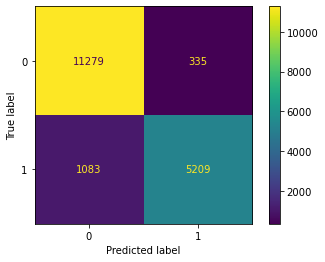

In [109]:
logreg = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

logreg.fit(x_train[use_cols],y_train)

displayMetrics(logreg, x_train[use_cols], x_test[use_cols], y_train, y_test)

In [110]:
# nb = Pipeline(steps=[
#     ('preproc', preprocessor),
#     ('gnb', GaussianNB())
# ])

# nb.fit(x_train[use_cols], y_train)

# displayMetrics(nb, x_train[use_cols], x_test[use_cols], y_train, y_test)


Train Accuracy:		1.0
Test Accuracy:		0.8994750363006814

Train Recall:		1.0
Test Recall:		0.8614113159567705

Train Precision:	1.0
Test Precision:		0.8538122243226213

Train f1:		1.0
Test f1:		0.8575949367088607

Train ROC-AUC:		1.0
Test ROC-AUC:		0.8907538756467166


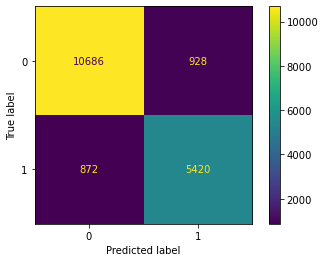

In [111]:
dt = Pipeline(steps=[
    ('preproc', preprocessor),
    ('tree', DecisionTreeClassifier())
])

dt.fit(x_train[use_cols], y_train)

displayMetrics(dt, x_train[use_cols], x_test[use_cols], y_train, y_test)

In [112]:
dt = Pipeline(steps=[
    ('preproc', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'tree__max_depth': [5,10,20,50,100],
    'tree__min_samples_leaf': [5,10,20,50,100]
}

dt_grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,scoring='recall')

dt_grid_search.fit(x_train[use_cols], y_train)

grid_dt = dt_grid_search.best_estimator_

displayMetrics(grid_dt, x_train[use_cols], x_test[use_cols], y_train, y_test)

KeyboardInterrupt: 